<a href="https://colab.research.google.com/github/yanisamrouche/data_science/blob/main/TP2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à la Science de Données
# TP2 -  Classification par les $k$ plus proches voisins


La documentation Scikit-learn sur les $k$ plus proches voisins se trouve ici: http://scikit-learn.org/stable/modules/neighbors.html


Avant de commencer, vérifiez les versions des paquets Python:

In [2]:
import sys
import numpy as np # importation du package numérique
import matplotlib
import sklearn

print('python: {} (version 3 obligatoire)'.format(sys.version))
print('numpy: {} (version conseillée mais pas obligatoire:)'.format(np.__version__))
print('matplotlib: {} (version conseillée mais pas obligatoire: 3.0.0 au moins)'.format(matplotlib.__version__))
print('scikit-learn: {} (version conseillée mais pas obligatoire: 0.19 au moins)'.format(sklearn.__version__))

python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0] (version 3 obligatoire)
numpy: 1.19.5 (version conseillée mais pas obligatoire:)
matplotlib: 3.2.2 (version conseillée mais pas obligatoire: 3.0.0 au moins)
scikit-learn: 0.22.2.post1 (version conseillée mais pas obligatoire: 0.19 au moins)


Une version récente de Matplotlib est particulièrement souhaitable pour que l'affichage des images se fasse correctement, sans "lissage".

## Données *digits*
Dans la première partie de ce TP, nous allons utiliser des données déjà présentes dans scikit-learn, à l'image des données Iris du premier TP.

Ces données sont très connues en apprentissage, sous le noms de MNIST. Elles sont composées d'images de chiffres manuscrits à une résolution de 8*8. En scikit-learn, elles se nomment digits : 

In [3]:
from sklearn.datasets import load_digits

digitsData=load_digits() # jeu de données digits
X=digitsData.data # les exemples, un array numpy, chaque élément est aussi un array
y=digitsData.target # les classes

On peut regarder quelques informations :

In [4]:
print(X.dtype, X.shape)
print(y.dtype, y.shape)

float64 (1797, 64)
int64 (1797,)


Chaque donnée est donc une image de 8 pixels par 8 pixels, en niveau de gris (256 nuances possibles), stockée sous la forme d'un vecteur de dimension 64 comme une ligne de la matrice X (il y a 1797 images) et avec la valeur de la classe associée stockée dans un vecteur Y à part (comme pour Iris). Mais on peut quand même regarder l'image initiale :




Le vecteur de l'image d'indice 42 :  [ 0.  0.  0.  9. 10.  0.  0.  0.  0.  0.  7. 16.  7.  0.  0.  0.  0.  0.
 13. 13.  1.  0.  0.  0.  0.  0. 15.  7.  0.  0.  0.  0.  0.  4. 16. 15.
 12.  7.  0.  0.  0.  2. 16. 12.  4. 11. 10.  0.  0.  0.  8. 14.  5.  9.
 14.  0.  0.  0.  0.  6. 12. 14.  9.  0.]
[[ 0.  0.  0.  9. 10.  0.  0.  0.]
 [ 0.  0.  7. 16.  7.  0.  0.  0.]
 [ 0.  0. 13. 13.  1.  0.  0.  0.]
 [ 0.  0. 15.  7.  0.  0.  0.  0.]
 [ 0.  4. 16. 15. 12.  7.  0.  0.]
 [ 0.  2. 16. 12.  4. 11. 10.  0.]
 [ 0.  0.  8. 14.  5.  9. 14.  0.]
 [ 0.  0.  0.  6. 12. 14.  9.  0.]]


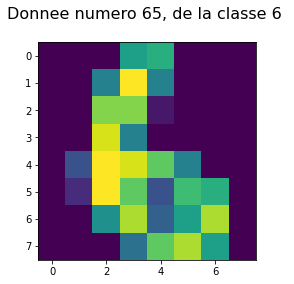

In [5]:
import matplotlib.pyplot as plt  # le package de visualisation
# la ligne spéciale pour que le notebook affiche comme il faut :
%matplotlib inline  
ix=65
donnee = X[ix,:] # on récupère une ligne, donc une donnée
classe = y[ix]   # et sa classe
print("Le vecteur de l'image d'indice 42 : ", donnee)

image = np.reshape(donnee,(8,8)) # on met les 8 morceaux de taille 8 du vecteur les uns en dessous des autres
print(image) # on affiche la matrice de pixels
plt.imshow(image) # on affiche l'image qui lui correspond
plt.title('Donnee numero %i, de la classe %i \n' % (ix, classe), fontsize = 16) # avec un titre
plt.show()

On peut faire des affichages plus intéressant, exemple sur les 5 premières données :

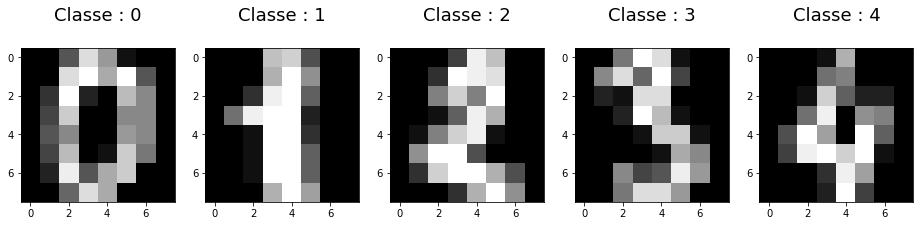

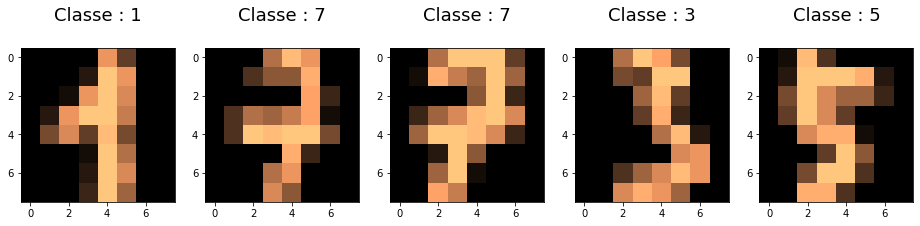

In [6]:
plt.figure(figsize=(16,4))
for index in range(5):
    image = X[index, :]
    classe = y[index]
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Classe : %i\n' % classe, fontsize = 18)
plt.show()
    
plt.figure(figsize=(16,4))
for index in range(5):
    image = X[42+index, :]
    classe = y[42+index]
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap="copper")
    plt.title('Classe : %i\n' % classe, fontsize = 18)  
plt.show()

## Création et entraînement d'un classifieur

Notre objectif est maintenant d'apprendre, sur la base d'un échantillon d'images "chiffres", un classifieur capable de prédire le chiffre qui correspond à une nouvelle image. Nous allons utiliser la méthode des $k$-plus proches voisins pour cet apprentissage. Elle est implémentée dans un package appelé neighbors. Examinons la série d'instructions suivante:

In [7]:
from sklearn import neighbors as nn # importation du package d'algorithmes travaillant sur les points voisins
help(nn.KNeighborsClassifier) # que fait cette instruction qui sera très utile par la suite?

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse o

Sympa, non ? Ce type d'instruction est utilisable pour toute classe de Python. 

Continuons l'exploration des $k$ plus proches voisins. Dans la série d'instructions suivante, on indique comment un classifieur peut être appris à partir de données étiquetées, et comment réaliser la prédiction sur un nouvel exemple.

Les fonctions *predict* et *fit* existent **pour tous les classifieurs** disponibles dans scikit-learn.

On note ici la syntaxe de la fonction predict: on lui passe en réalité un tableau d'exemples (ici, un tableau avec un seul exemple constitué de 64 attributs), et elle renvoit un tableau contenant la classe prédite pour chaque exemple du tableau en paramètre. Evidemment, dans les tableaux en entrée et en sortie, les indices des classes prédites correspondent aux indices des exemples en entrée ! 

Ainsi, lorsque l'on sait que l'on n'applique predict qu'à un seul exemple, une sélection finale [0] comme ci-après renvoit la première (et la seule) composante du tableau de résultat. 

In [8]:
nb_voisins = 15 # on fixe le nombre de voisins, à partir de 2 et au max le nombre d'exemples dans le jeu de données
clf = nn.KNeighborsClassifier(nb_voisins) 
# ci-dessus, création d'un classifieur: la variable clf est un "objet" classifieur, vide pour l'instant 
#print(clf) # le classifieur est vide pour l'instant, il n'a pas été entraîné sur des données
clf.fit(X, y) # entraînement du classifieur clf sur les données étiquetées
nouvel_ex = X[50, :]  # On extrait la 50e image
print('prédiction pour le nouvel exemple: ',
      clf.predict(nouvel_ex.reshape(1,-1))) # prédiction du modèle appris sur la description d'une image aléatoire

prédiction pour le nouvel exemple:  [2]


In [9]:
print('prédiction pour le nouvel exemple: ', clf.predict(nouvel_ex.reshape(1,-1))[0])

prédiction pour le nouvel exemple:  2


Pour certains types de classifieurs, on peut même récupérer la probabilité que le classifieur attribue à l'appartenance de l'exemple à chaque classe possible. La fonction *predict_proba* fonctionne comme la fonction *predict*, sauf que le tableau en sortie contient, pour chaque exemple du tableau en entrée, un tableau de probabilité de la même taille que le nombre de classes.

In [10]:
autre_ex = X[123, :] # on génère un autre exemple en prenant une autre image
print(clf.predict_proba(nouvel_ex.reshape(1,-1))[0]) # probabilité d'appartenance à chaque classe pour ce chiffre
print(clf.predict_proba(autre_ex.reshape(1,-1))[0]) # idem pour un autre exemple

[0.  0.  0.8 0.  0.  0.  0.  0.  0.2 0. ]
[0.         0.46666667 0.         0.         0.         0.
 0.         0.         0.53333333 0.        ]


A votre avis, quelle classe sera attribuée au deuxième exemple, et pourquoi ? Indiquez ci-après l'instruction à exécuter pour vérifier. 

In [11]:
# a vous
print('prédiction pour le nouvel exemple: ',
      clf.predict(autre_ex.reshape(1,-1))) # prédiction du modèle appris sur la description d'une image aléatoire


prédiction pour le nouvel exemple:  [8]


Une première façon d'évaluer la qualité d'un classifieur est de le tester sur les exemples qui ont servi à l'apprendre. On utilise du coup la même fonction *predict*, appliquée au tableau des exemples d'apprentissage. 

In [12]:
f_X = clf.predict(X) # vecteur des classes prédites pour chaque exemple de l'ensemble d'apprentissage
print(f_X)
X[f_X!=y].shape
#print(X[f_X!=y]) # le tableau d'exemples pour lesquels la prédiction a été mauvaise

[0 1 2 ... 8 9 8]


(26, 64)

Pour vous rendre compte de l'origine possible des erreurs de prédiction, faites une boucle sur toutes les images pour lesquelles la prédiction est erronnée en affichant à chaque fois l'image 8x8 avec dans le titre l'indice de l'image, la classe originale et la classe prédite (pour cela, on peut utiliser la fonction *numpy.argwhere* avec un peu de jugeotte).

[[ 0.  0. 12. 10.  0.  0.  0.  0.]
 [ 0.  0. 14. 16. 16. 14.  0.  0.]
 [ 0.  0. 13. 16. 15. 10.  1.  0.]
 [ 0.  0. 11. 16. 16.  7.  0.  0.]
 [ 0.  0.  0.  4.  7. 16.  7.  0.]
 [ 0.  0.  0.  0.  4. 16.  9.  0.]
 [ 0.  0.  5.  4. 12. 16.  4.  0.]
 [ 0.  0.  9. 16. 16. 10.  0.  0.]]


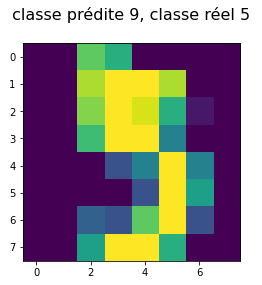

[[ 0.  0.  6. 12. 13.  6.  0.  0.]
 [ 0.  6. 16.  9. 12. 16.  2.  0.]
 [ 0.  7. 16.  9. 15. 13.  0.  0.]
 [ 0.  0. 11. 15. 16.  4.  0.  0.]
 [ 0.  0.  0. 12. 10.  0.  0.  0.]
 [ 0.  0.  3. 16.  4.  0.  0.  0.]
 [ 0.  0.  1. 16.  2.  0.  0.  0.]
 [ 0.  0.  6. 11.  0.  0.  0.  0.]]


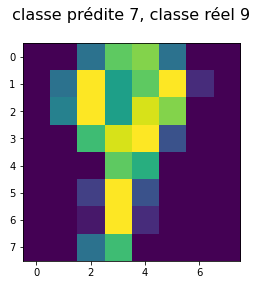

[[ 0.  0.  0.  0. 11. 15.  4.  0.]
 [ 0.  0.  0.  3. 16. 16. 12.  0.]
 [ 0.  0.  0.  8. 14. 16. 12.  0.]
 [ 0.  0.  0.  5. 10. 16.  6.  0.]
 [ 0.  1.  7. 11. 16. 13.  0.  0.]
 [ 0.  9. 16. 16. 14.  1.  0.  0.]
 [ 0.  3.  8. 14. 16.  9.  0.  0.]
 [ 0.  0.  0.  1. 11. 16. 12.  0.]]


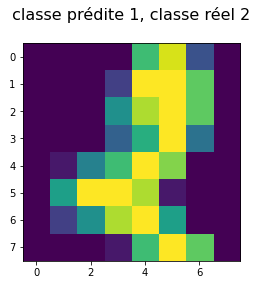

[[ 0.  0.  0.  9. 16.  4.  0.  0.]
 [ 0.  1.  9. 16. 13.  2.  0.  0.]
 [ 0. 14. 16. 14.  8.  0.  0.  0.]
 [ 1. 15. 15.  5. 16.  9.  0.  0.]
 [ 0.  5. 16. 16. 16.  8.  0.  0.]
 [ 0.  0.  2. 13. 16.  1.  0.  0.]
 [ 0.  0.  0. 11. 13.  0.  0.  0.]
 [ 0.  0.  0. 11. 13.  0.  0.  0.]]


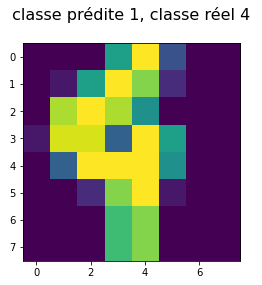

[[ 0.  0.  7. 13. 15.  5.  0.  0.]
 [ 0.  0.  8. 16. 16. 12.  0.  0.]
 [ 0.  0.  7. 16. 15.  3.  0.  0.]
 [ 0.  0.  6. 16.  5.  0.  0.  0.]
 [ 0.  0.  5. 16.  2.  0.  0.  0.]
 [ 0.  0.  8. 16.  6.  0.  0.  0.]
 [ 0.  0. 12. 12. 13.  0.  0.  0.]
 [ 0.  0.  5. 13. 10.  0.  0.  0.]]


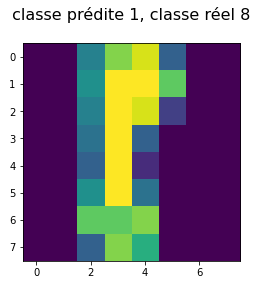

[[ 0.  0.  2. 13.  4.  0.  0.  0.]
 [ 0.  0.  8. 14. 11.  0.  0.  0.]
 [ 0.  0. 10.  6. 14.  5.  2.  0.]
 [ 0.  0.  2. 14. 12. 14.  0.  0.]
 [ 0.  0.  1. 15. 13.  2.  0.  0.]
 [ 0.  0. 11. 13. 14.  1.  0.  0.]
 [ 0.  0. 13.  8. 10.  4.  0.  0.]
 [ 0.  0.  2. 11. 16.  7.  0.  0.]]


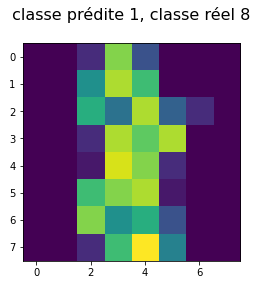

[[ 0.  0.  4. 11. 14.  4.  0.  0.]
 [ 0.  5. 13.  4.  9.  7.  0.  0.]
 [ 0.  7. 10. 10. 13.  2.  0.  0.]
 [ 0.  1.  9. 16. 15.  2.  0.  0.]
 [ 0.  0.  8.  7.  9. 12.  0.  0.]
 [ 0.  0. 12.  0.  1. 14.  5.  0.]
 [ 0.  0. 11.  6.  0.  7.  8.  0.]
 [ 0.  0.  2. 15. 16. 15.  4.  0.]]


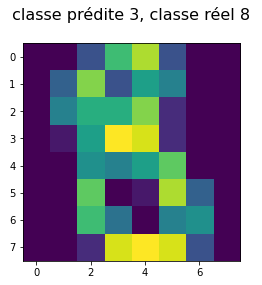

[[ 0.  0. 11. 10. 12. 14. 11.  0.]
 [ 0.  0. 16. 16. 16. 16.  7.  0.]
 [ 0.  1. 16. 16. 16. 12.  0.  0.]
 [ 0.  1.  5.  2. 11. 15.  0.  0.]
 [ 0.  0.  1.  0.  2. 16.  0.  0.]
 [ 0.  3. 12.  0.  3. 15.  0.  0.]
 [ 0.  6. 15.  8. 13. 11.  0.  0.]
 [ 0.  0.  9. 14.  9.  2.  0.  0.]]


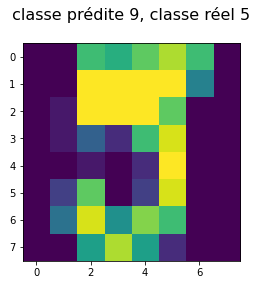

[[ 0.  0.  0. 11. 16. 12.  1.  0.]
 [ 0.  0.  5. 16. 10. 16.  4.  0.]
 [ 0.  2. 15. 10.  0.  8.  1.  0.]
 [ 0.  5. 16.  9.  1.  0.  0.  0.]
 [ 0.  8. 16. 16.  9.  0.  0.  0.]
 [ 0.  2. 16. 10. 16.  6.  0.  0.]
 [ 0.  0. 11. 16. 16.  7.  0.  0.]
 [ 0.  0.  1.  8. 13.  0.  0.  0.]]


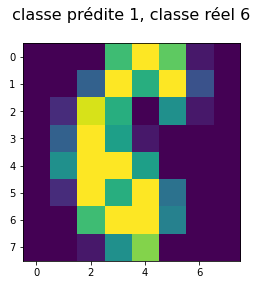

[[ 0.  0.  2. 10. 16. 11.  1.  0.]
 [ 0.  0. 13. 13. 10. 16.  8.  0.]
 [ 0.  4. 14.  1.  8. 14.  1.  0.]
 [ 0.  4. 15. 12. 15.  8.  0.  0.]
 [ 0.  0.  6.  7. 14.  5.  0.  0.]
 [ 0.  1.  2.  0. 12.  5.  0.  0.]
 [ 0.  8. 15.  6. 13.  4.  0.  0.]
 [ 0.  0.  5. 11. 16.  3.  0.  0.]]


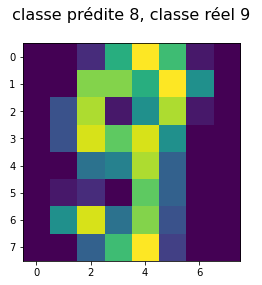

[[ 0.  0.  0.  1. 12. 16. 14.  0.]
 [ 0.  0.  3. 14. 13. 15. 13.  0.]
 [ 0.  4. 16. 15. 13. 16.  4.  0.]
 [ 0.  3. 16. 16. 16. 16.  3.  0.]
 [ 0.  0.  7.  7. 14. 14.  0.  0.]
 [ 0.  0.  0.  0. 12. 11.  0.  0.]
 [ 0.  0.  0.  0. 13. 10.  0.  0.]
 [ 0.  0.  0.  0. 13. 12.  0.  0.]]


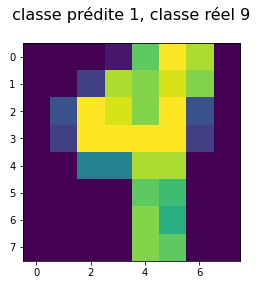

[[ 0.  0.  1. 14.  8.  8.  1.  0.]
 [ 0.  0. 10. 13.  8. 16.  1.  0.]
 [ 0.  2. 16.  4. 10. 11.  0.  0.]
 [ 0.  7. 15.  6. 14. 16. 13.  0.]
 [ 0.  3. 16. 16. 15.  9.  2.  0.]
 [ 0.  0.  3. 11.  9.  0.  0.  0.]
 [ 0.  0.  0. 12.  4.  0.  0.  0.]
 [ 0.  0.  0. 12.  0.  0.  0.  0.]]


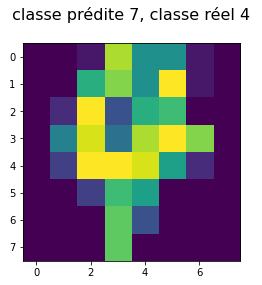

[[ 0.  0.  0.  2. 15.  5.  0.  0.]
 [ 0.  0.  2.  4. 10. 12.  0.  0.]
 [ 0.  3. 15. 14. 10.  8.  0.  0.]
 [ 0.  8. 15.  1. 11.  4.  0.  0.]
 [ 0.  1.  8. 15. 16.  0.  0.  0.]
 [ 0.  0.  0.  6. 16. 12.  1.  0.]
 [ 0.  0.  0.  4. 14. 15.  4.  0.]
 [ 0.  0.  0.  2. 14. 11.  0.  0.]]


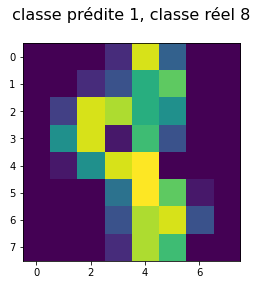

[[ 0.  0.  4. 12. 16. 16.  4.  0.]
 [ 0.  0.  9.  7.  4. 14. 12.  0.]
 [ 0.  0.  0.  0.  0. 11. 14.  0.]
 [ 0.  0.  0.  0.  3. 16.  6.  0.]
 [ 0.  0.  0.  1. 13.  6.  0.  0.]
 [ 0.  0.  1. 12.  8.  0.  0.  0.]
 [ 0.  0.  6. 16.  9.  5.  0.  0.]
 [ 0.  0.  3. 12. 13.  9.  0.  0.]]


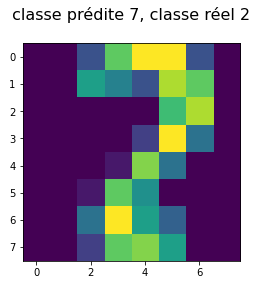

[[ 0.  0.  6. 14. 16.  5.  0.  0.]
 [ 0.  2. 16. 16. 16.  7.  0.  0.]
 [ 0.  2. 15. 16. 15.  2.  0.  0.]
 [ 0.  0.  6. 16. 15.  7.  0.  0.]
 [ 0.  0. 14. 10.  6. 16.  3.  0.]
 [ 0.  1. 16.  3.  0. 16.  7.  0.]
 [ 0.  0. 10. 11. 11. 15.  3.  0.]
 [ 0.  0.  3. 14. 16.  6.  0.  0.]]


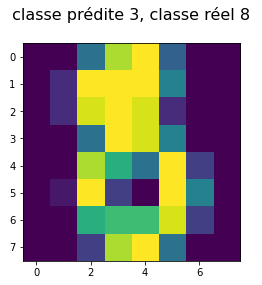

[[ 0.  0.  2.  8.  7.  0.  0.  0.]
 [ 0.  0.  6. 15. 16.  2.  0.  0.]
 [ 0.  6. 15. 11. 16.  4.  0.  0.]
 [ 0.  5. 16. 10. 16.  1.  0.  0.]
 [ 0.  2. 15. 16. 13.  0.  0.  0.]
 [ 0.  0.  2. 16. 12.  9.  3.  0.]
 [ 0.  0.  4. 14.  0. 12. 14.  1.]
 [ 0.  0.  1. 12. 10.  7.  0.  0.]]


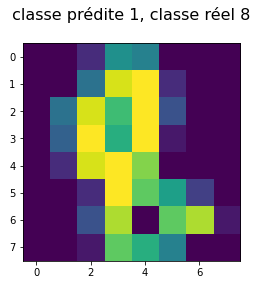

[[ 0.  0.  3. 11. 14. 12.  3.  0.]
 [ 0.  2. 13. 10.  4. 10. 12.  0.]
 [ 0.  2. 11.  2.  0.  9.  9.  0.]
 [ 0.  0.  0.  3. 10. 10.  1.  0.]
 [ 0.  0.  7. 16. 16.  2.  0.  0.]
 [ 0.  0.  3.  0. 14.  3.  0.  0.]
 [ 0.  0.  0.  1. 13.  2.  0.  0.]
 [ 0.  3.  7. 14.  5.  0.  0.  0.]]


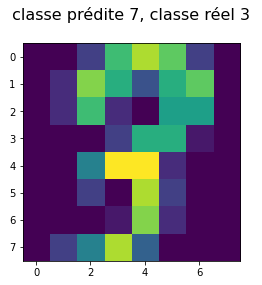

[[ 0.  0.  4.  9. 13. 13.  0.  0.]
 [ 0.  1. 13. 15.  6.  2.  0.  0.]
 [ 0.  0.  9.  7.  0.  0.  0.  0.]
 [ 0.  0. 13.  3.  4.  0.  0.  0.]
 [ 0.  2. 16. 16. 16.  8.  0.  0.]
 [ 0.  2. 11.  3.  0. 10.  4.  0.]
 [ 0.  0.  2.  5.  4. 15.  1.  0.]
 [ 0.  0.  3. 12. 14.  8.  0.  0.]]


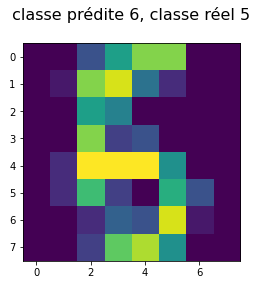

[[ 0.  0.  1.  8. 13.  1.  0.  0.]
 [ 0.  0.  6. 16. 16.  9.  0.  0.]
 [ 0.  1. 15. 16. 16. 10.  0.  0.]
 [ 0.  6. 15. 14.  6.  0.  0.  0.]
 [ 0.  3.  7.  6.  6.  0.  0.  0.]
 [ 0.  1. 10.  2. 11.  0.  0.  0.]
 [ 0.  0.  4. 11. 13.  2.  0.  0.]
 [ 0.  0.  0.  5. 12.  5.  0.  0.]]


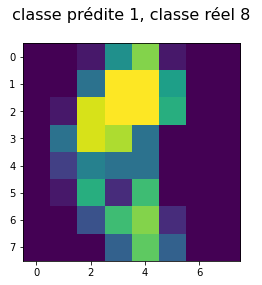

[[ 0.  0.  6. 14. 16. 15.  1.  0.]
 [ 0.  9. 16. 12.  9. 16.  3.  0.]
 [ 0. 12. 16. 11. 14. 13.  0.  0.]
 [ 0.  7. 15. 16. 14.  0.  0.  0.]
 [ 0.  0.  2.  8. 16.  5.  0.  0.]
 [ 0.  0.  0.  6. 16.  4.  0.  0.]
 [ 0.  0.  2. 13. 12.  0.  0.  0.]
 [ 0.  0.  9. 16.  1.  0.  0.  0.]]


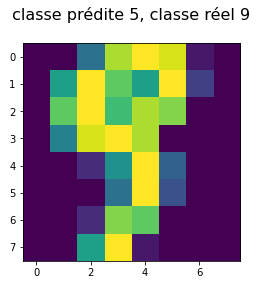

[[ 0.  0. 10. 14.  0.  0.  0.  0.]
 [ 0.  1. 16.  7.  1.  7.  0.  0.]
 [ 0.  0. 15.  7. 12. 16.  2.  0.]
 [ 0.  0. 10. 16. 16.  4.  0.  0.]
 [ 0.  0.  0.  9. 14.  0.  0.  0.]
 [ 0.  0.  0. 14. 10.  0.  0.  0.]
 [ 0.  0.  5. 16.  2.  0.  0.  0.]
 [ 0.  0. 11. 12.  0.  0.  0.  0.]]


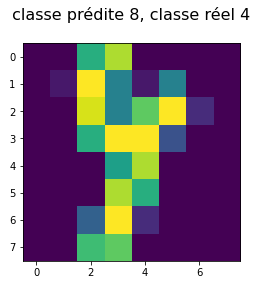

[[ 0.  0.  7. 16. 16.  8.  0.  0.]
 [ 0.  0. 14. 12. 11. 14.  0.  0.]
 [ 0.  0. 11. 15. 16. 12.  0.  0.]
 [ 0.  0.  5. 15. 15.  4.  0.  0.]
 [ 0.  0.  0.  3. 12. 14.  0.  0.]
 [ 0.  1. 10.  0.  7. 15.  0.  0.]
 [ 0.  1. 14.  6. 13. 12.  0.  0.]
 [ 0.  0.  7. 16. 16. 11.  0.  0.]]


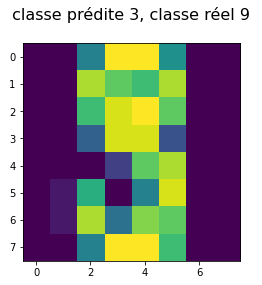

[[ 0.  0. 11.  7.  0.  0.  0.  0.]
 [ 0.  5. 16.  3.  2. 14.  3.  0.]
 [ 0.  9. 15.  0. 12. 15.  0.  0.]
 [ 0.  6. 16. 15. 16.  5.  0.  0.]
 [ 0.  0.  6. 15. 11.  0.  0.  0.]
 [ 0.  0.  1. 16.  4.  0.  0.  0.]
 [ 0.  0.  9. 12.  0.  0.  0.  0.]
 [ 0.  0. 13. 10.  0.  0.  0.  0.]]


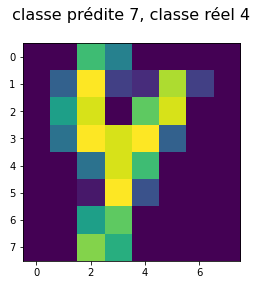

[[ 0.  0.  7. 15. 16. 12.  0.  0.]
 [ 0. 12. 16. 11. 16. 13.  0.  0.]
 [ 0. 15. 16. 16. 14.  5.  0.  0.]
 [ 0.  8. 16. 12.  0.  0.  0.  0.]
 [ 0.  0.  2. 12.  9.  0.  0.  0.]
 [ 0.  0.  0.  9. 13.  0.  0.  0.]
 [ 0.  0.  2. 16.  8.  0.  0.  0.]
 [ 0.  0. 10. 12.  1.  0.  0.  0.]]


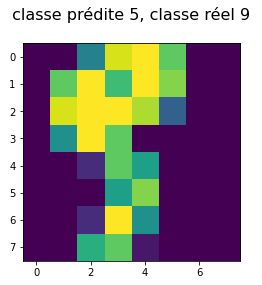

[[ 0.  1.  7. 13. 16. 13.  0.  0.]
 [ 0.  7. 16. 16. 16. 14.  0.  0.]
 [ 0.  1.  7. 16. 10.  1.  0.  0.]
 [ 0.  1. 16. 15.  0.  0.  0.  0.]
 [ 0.  0.  8. 15. 14.  3.  0.  0.]
 [ 0.  0.  0.  1. 14. 15.  3.  0.]
 [ 0.  0.  1.  5. 13. 16.  7.  0.]
 [ 0.  0.  8. 15. 10.  6.  0.  0.]]


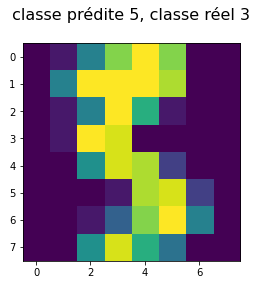

[[ 0.  0.  5. 12.  8.  0.  1.  0.]
 [ 0.  0. 11. 16.  5. 13.  6.  0.]
 [ 0.  0.  2. 15. 16. 12.  1.  0.]
 [ 0.  0.  0. 10. 16.  6.  0.  0.]
 [ 0.  0.  1. 15. 16.  7.  0.  0.]
 [ 0.  0.  8. 16. 16. 11.  0.  0.]
 [ 0.  0. 11. 16. 16.  9.  0.  0.]
 [ 0.  0.  6. 12. 12.  3.  0.  0.]]


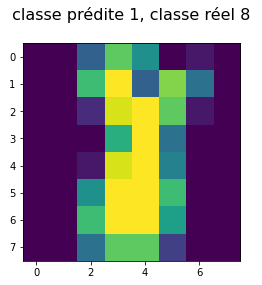

In [13]:
table_x =X[f_X!=y]
faux_X = np.argwhere(f_X!=y)
for i in (faux_X): 
    image = np.reshape(X[i,:],(8,8)) # on met les 8 morceaux de taille 8 du vecteur les uns en dessous des autres
    print(image) # on affiche la matrice de pixels
    plt.imshow(image) # on affiche l'image qui lui correspond
    plt.title(' classe prédite %i, classe réel %i \n' % (f_X[i],y[i]), fontsize = 16) # avec un titre
    plt.show()


  

Chaque classifieur possède une fonction score, qui permet de comparer les prédictions d'un ensemble d'exemples $X$ pour lesquelles on connaît les étiquettes $y$ : la fonction calcule le taux de bonne classifications. 

In [14]:
print('taux de bonne classification', clf.score(X,y)) # taux de bonne classification du modèle sur l'ensemble d'apprentissage: fonction score

taux de bonne classification 0.9855314412910406


On la détourne facilement pour obtenir le taux d'erreur: faites le (vous devez obtenir 0.01446855...)!

In [23]:
# a vous
print('taux d erreur', 1-clf.score(X,y))

taux d erreur 0.014468558708959356


## Variation du nombre de voisins

L'algorithme des $k$-plus proches voisins fonctionne avec plusieurs hyper-paramètres (paramètres de l'agorithme, pas du modèle appris): la valeur de $k$ est un de ces paramètres. Réalisez un programme qui fait varier cet hyper-paramètres dans un intervalle comprenant des valeurs entre 1 et 15, et stocker l'évolution de l'erreur d'apprentissage (celle calculée sur l'échantillon d'apprentissage), puis en réaliser une courbe avec en abscisse les valeurs de k, et en ordonnées les erreurs.

On peut utiliser pour ce faire la fonction de construction d'un tableau *numpy.arange* (cf documentation), la fonction *len(X)* qui renvoit la taille d'un tableau à une dimension. Pour la courbe, on utilisera simplement *plot(abs, ord)* du package *pyplot* de *matplotlib*, comme vue au premier TP.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


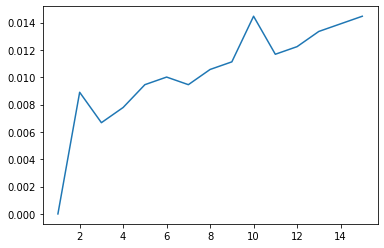

In [36]:
# a vous

max_neighbors = 15
t_err = []
n = []

for i in range(max_neighbors):
  n.append(i+1)
  cl = nn.KNeighborsClassifier(i+1)
  cl.fit(X, y)
  taux_err = 1 - cl.score(X, y)
  t_err.append(taux_err)
print(n)
plt.plot(n,t_err)  
plt.show()



Qu'observez-vous ? A quelle valeur de k atteint-on un meilleur classifieur ? Quelle est globalement, sur ce jeu de données, l'influence de $k$? Que se passe-t-il exactement pour $k=1$?

## Evaluation de l'erreur réelle du classifieur appris 

Lorsque le score du classifieur appris est évalué sur l'ensemble d'apprentissage, il est en général sur-estimé (pourquoi ?) et donc, très peu fiable. La meilleure méthode pour évaluer un classifieur consiste à calculer son score sur un échantillon test, indépendant de l'échantillon d'apprentissage mais généré dans les mêmes
conditions. Lorsqu'on dispose d'un seul ensemble d'exemples (comme c'est le cas de *digits*, il faut donc:

* répartir les données en un sous-ensemble d'apprentissage et un sous-ensemble test,
* entrainer un classifieur sur l'ensemble d'apprentissage 
* évaluer ce classifieur sur l'ensemble test (on a ici une évaluation de l'erreur réelle, qui reste instable puisque dépend du découpage effectué)

Si les données sont peu nombreuses, comme c'est le cas pour le jeu de données *digits*, cette évaluation risque d'être pessimiste (avez-vous une idée de pourquoi ? Si oui, expliquez, sinon réfléchissez!).

Scikit-learn vient avec toute une panoplie d'outils pour évaluer cette erreur. Pour l'instant, nous n'utiliserons que la fonction qui permet de diviser un échantillon en deux parties (attributs et classes): c'est la fonction *train_test_split* du package *model_selection*, que nous appliquons ci-après sur Iris (nous ne printons que les trois premiers exemples de chaque sous-échantillon, avec leurs étiquettes):


In [17]:
from sklearn.model_selection import train_test_split
# production de deux sous-échantillon
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25, random_state=42) 
print(Xtrain[:3,:], ytrain[:3])
print(Xtest[:3,:], ytest[:3])

[[ 0.  0.  2. 15. 15. 16. 11.  0.  0.  0.  8. 16. 11.  3.  0.  0.  0.  0.
  13.  9.  0.  0.  0.  0.  0.  5. 16.  3.  9. 11.  3.  0.  0. 10. 15. 15.
  16. 16. 11.  0.  0.  6. 16. 10.  7. 16.  5.  0.  0.  0.  3.  4. 15.  8.
   0.  0.  0.  0.  4. 15.  7.  0.  0.  0.]
 [ 0.  5. 16. 15.  3.  0.  0.  0.  0. 11. 14. 11. 11.  0.  0.  0.  0.  8.
  11.  4. 16.  0.  0.  0.  0.  0.  0.  4. 13.  0.  0.  0.  0.  0.  0.  8.
  12.  0.  0.  0.  0.  0.  0. 13.  9.  5.  1.  0.  0.  1. 11. 16. 16. 16.
  10.  0.  0.  5. 16. 14.  8.  6.  1.  0.]
 [ 0.  0.  4. 13.  8.  0.  0.  0.  0.  0. 13. 16. 15.  7.  0.  0.  0.  3.
  16.  9.  6. 15.  6.  0.  0.  8. 14.  0.  0.  4.  8.  0.  0.  8. 12.  0.
   0.  4.  8.  0.  0.  4. 12.  0.  0. 11.  6.  0.  0.  0. 14. 10. 12. 14.
   1.  0.  0.  0.  7. 15. 11.  2.  0.  0.]] [5 2 0]
[[ 0.  0.  0.  7. 12.  0.  0.  0.  0.  0.  4. 16.  8.  0.  0.  0.  0.  0.
  12. 11.  0.  0.  0.  0.  0.  0. 15. 10.  8.  6.  1.  0.  0.  0. 15. 16.
   8. 10.  8.  0.  0.  0. 14.  7.  0.  0. 12.  0

Ici, nous produisons un découpage dans lequel l'ensemble d'apprentissage représente 75% de l'échantillon initial, et l'échantillon de test représente 25% des données initiales.

En vous inspirant de ce mode de découpage, écrire une séquence d'instructions permettant de séparer *digits* en deux parties égales, d'apprendre un 3-plus proches voisins sur le premier sous-échantillon, et de le tester sur le second: vous obtenez une **estimation** de l'erreur réelle. Obtenez-vous la même erreur que celle d'apprentissage mesurée précédemment ?

In [37]:
# a vous
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.50, random_state=42) 
c = nn.KNeighborsClassifier(3)
c.fit(X_train, y_train)
t_err = 1 - c.score(X_test, y_test)
print(t_err)

0.013348164627363768


Faites maintenant à nouveau varier $k$, et pour chaque valeur, indiquez l'erreur réelle estimée sur la base d'un train_test_split de 70%, 30% ; tracer la courbe. Observez-bien les différences de valeurs des erreurs d'apprentissage et réelle: pourquoi sont-elles différentes ? Que constatez-vous ?

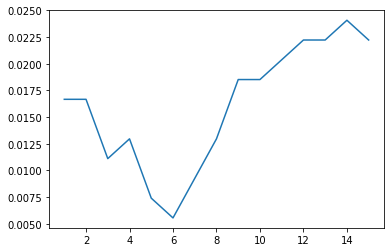

In [38]:
# a vous
max_neighbors = 15
t_err_ = []
v = []
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42) 
for i in range(max_neighbors):
  v.append(i+1)
  c = nn.KNeighborsClassifier(i+1)
  c.fit(X_train, y_train)
  taux_err = 1 - c.score(X_test, y_test)
  t_err_.append(taux_err)
plt.plot(n,t_err_)
plt.show()

## Variation autour de la métrique

Au delà du nombre de voisins, un autre hyper-paramètre est la métrique utilisée pour calculer la distance entre les exemples. Par défaut, la distance de Minkowski est utilisée, avec le paramètre $p=2$ qui indique que nous considérons la distance euclidienne. Avec $p=1$, nous aurions la distance de manhattan, et de façon générale, avec p>0, la distance utilisée est $l_p$ :

$$l_p(x, x')=(\sum_{i=1}^n |x_i - x'_i|^p)^{\frac{1}{p}}$$

Ecrire un programme permettant de faire varier la distance utilisée pour évaluer son impact sur les performances, en faisant aussi varier $k$. Tracez les 3 courbes sur un même plot (cf. doc de *plot* pour voir comment faire), une pour chaque valeur de $p$ parmi ${1,2,5}$.

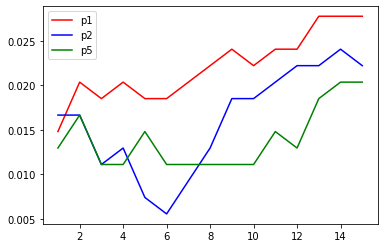

In [54]:
# a vous
max_neighbors = 15
t_err_ = []
v = []
P = [1, 2, 5]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42) 
for p in P:
  for i in range(max_neighbors):
    k = i+1
    v.append(k)
    c = nn.KNeighborsClassifier(k, p=p)
    c.fit(X_train, y_train)
    taux_err = 1 - c.score(X_test, y_test)
    t_err_.append(taux_err)
  if(p == 1):  
    plt.plot(n,t_err_, "-r", label="p1")
  if(p == 2):
    plt.plot(n,t_err_, "-b", label="p2")
  if(p == 5):
    plt.plot(n,t_err_, "-g", label="p5")
  t_err_.clear()
plt.legend()
plt.show()
 

## Matrice de confusion
Maintenant que vous avez sélectionné les meilleurs valeurs de $k$ et $p$, vous pouvez analyser plus finement les performances de votre meilleur classifieur. Pour cela, construisez la matrice de confusion, de taille $10 \times 10$, dans laquelle l'éléments $(i,j)$ correspond au nombre de fois qu'un exemple d'étiquette $i$ a été prédit avec une étiquette $j$. Quelles sont les confusions fréquentes?

In [57]:
# a vous
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42) 
c = nn.KNeighborsClassifier(6, p=2)
c.fit(X_train, y_train)
y_pred = c.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 54,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 60,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 66,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 53,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 55,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 43,  0],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0, 56]])

Optionnel.
Une manipulation intéressante à faire consiste à retourner les images en leur faisant subir une rotation à 180º: de cette façon, les 6 ressemblent ensuite à des 9 et vice-versa, les 0 restent des 0, et les autres chiffres donnent parfois des caractères indéfinis. Faites des essais sur quelques exemples en les affichant pour trouver comment retourner une image, puis appliquez un k-NN ainsi: apprenez sur tout l'ensemble d'images originales, testez sur l'ensemble de toutes les images retournées, affichez la matrice de confusion pour voir dans quelle mesure les 6 sont reconnus comme des 9 et observez d'autres phénomènes.

In [ ]:
# a vous
